<a href="https://colab.research.google.com/github/danieljai/CIND820-AndyLee/blob/main/AndyLee_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 4: Preload setup

Basic setup so results can utilize the full width of the screen.

In [1]:
%config IPCompleter.greedy=True
import pandas as pd

pd.set_option('display.max_colwidth', 200)
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 100

# Step 5: Import Dataset

The hydrated file is stored in a Google Drive, and using the follow code will mount Google Drive onto Colaboratory.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

df = pd.read_csv("/content/drive/My Drive/__CIND 820 - Data Analytics Project/3-data/Book1-fastsave.csv")

# Step 6. Data Cleaning and Manipulation

## Preview data after cleaning and manipulation

Original Tweet dataframe datatypes

In [8]:
# https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/overview/user-object
dfOriginals.dtypes

coordinates                    object
created_at                     object
hashtags                       object
media                          object
urls                           object
favorite_count                  int64
id                              int64
in_reply_to_screen_name        object
in_reply_to_status_id           int64
in_reply_to_user_id             int64
lang                           object
place                          object
possibly_sensitive             object
retweet_count                   int64
retweet_id                      int64
retweet_screen_name            object
source                         object
text                           object
tweet_url                      object
user_created_at                object
user_screen_name               object
user_default_profile_image       bool
user_description               object
user_favourites_count           int64
user_followers_count            int64
user_friends_count              int64
user_listed_

## Readjust attribute datatype

For `retweet_id`, `in_reply_to_status_id`, `in_reply_to_user_id`
- Convert `null` values to 0
- Convert attribute as int64

In [4]:
df.retweet_id = df[df['retweet_id'].notnull()].retweet_id.astype('int64') 

In [5]:
df.retweet_id = df.retweet_id.fillna(0).astype('int64')
df.in_reply_to_status_id = df.in_reply_to_status_id.fillna(0).astype('int64')
df.in_reply_to_user_id = df.in_reply_to_user_id.fillna(0).astype('int64')

## Misc. cleaning up to reduce noise when conducting sentimental analysis
1. remove \n
2. remove URL
3. remove user referrals
4. remove hashtags

In [6]:
df['modified_text'] = df.text.str.replace(r'\n', '')
df['modified_text'] = df.modified_text.str.replace(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '')
df['modified_text'] = df.modified_text.str.replace(r'\B@\w+', '')
df['modified_text'] = df.modified_text.str.replace(r'\B#\w+', '')

## Splitting Dataframes (originals and retweets)

The collection includes both original tweets and retweets. Since retweets mirrors the original tweet by someone else other than the author, we don't need to run sentimental analysis on the retweet as it would have been run on the original tweet, therefore we can split original tweets and retweets into two dataframes to avoid wasting resources.


- Original tweets: `dfOriginals`
- Retweets: `dfRetweets` cons





In [7]:
dfOriginals = df[df.retweet_id == 0]
dfRetweets = df[df.retweet_id != 0]

Two samples of the original tweet dataframe.

In [9]:
dfOriginals.sample(2)

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,lang,place,possibly_sensitive,retweet_count,retweet_id,retweet_screen_name,source,text,tweet_url,user_created_at,user_screen_name,user_default_profile_image,user_description,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified,modified_text
552018,NaN,Tue Mar 31 19:50:11 +0000 2020,NaN,NaN,NaN,0,1245075941891727360,RealBobMortimer,1245068174720208896,310960217,en,NaN,NaN,0,0,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",@RealBobMortimer How's Train Guy? Hope he's managed to smug out the Corona!,https://twitter.com/vagrant_radio/status/1245075941891727360,Thu Feb 15 19:25:39 +0000 2018,vagrant_radio,False,"Out of K Pop combo Weetman Dogpile.\n""Sound of the smell of dog turds baking in the sun""-Neil Kulkarni\n""I hope they die!"" - Luke Haines",14045,132,371,0,Q Continuum,Bobby 'You Pay For What You Get' Bollocks,vagrant_radio,14977,NaN,https://everypuddle.blogspot.com/,False,How's Train Guy? Hope he's managed to smug out the Corona!
781745,NaN,Wed Apr 01 04:38:13 +0000 2020,NaN,NaN,NaN,0,1245208826346762241,huanxin_zhang,1245204721586991104,1207578629095321600,en,NaN,NaN,0,0,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@huanxin_zhang @GodAlcove @9r0UKMhqt8AfSce @Liz_Wheeler Taiwan has corona so that means China has corona again?,https://twitter.com/yakoblootz/status/1245208826346762241,Thu Mar 19 17:08:53 +0000 2020,yakoblootz,False,Flame trooper Veteran of the E.Musk space confederation. Aspiring to be a mech pilot/ engineer. if given the opportunity I would go back to kill more communists,203,6,34,0,NaN,Yakoblootz,yakoblootz,344,NaN,NaN,False,Taiwan has corona so that means China has corona again?


## Guessing language

Since our sentiment analysis focuses on only English tweets, we will install a `langdetect` library to help filter out tweets that are not English.

In [10]:
#https://pypi.org/project/langdetect/
!pip install langdetect
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0



Function to test whether tweet is English with error handling.

In [11]:
#https://stackoverflow.com/questions/60930935/exclude-non-english-rows-in-pandas

def is_en(txt):
    try:
        return detect(txt)=='en'
    except:
        return False

Passing as the `is_en()` as first-class function; returning a boolean value as a attribute `guessed_language`.

In [12]:
dfOriginals['guessed_language'] = dfOriginals.modified_text.apply(is_en)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


By filtering out non-English tweets, we remove noise that can potentially affect our sentimental analysis.

In [13]:
print("There are " + str(len(dfOriginals)) + " tweets in total, and " + str(sum(dfOriginals.guessed_language)) + " detects as English.")
print("Percentage of tweets that are in English: " + str(round((sum(dfOriginals.guessed_language) / len(dfOriginals)) * 100, 4)) + "%")


There are 245389 tweets in total, and 232816 detects as English.
Percentage of tweets that are in English: 94.8763%


# Step 7. Sentiment Analysis

To conduct Seitment Analysis, we begin by importing the NLTK library.

In [14]:
import nltk
from nltk.sentiment.util import *
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import tokenize
nltk.download('punkt')
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Applying Sentiment Analysis function

We apply the polarity score function and store results on a new attribute `sentimentscore`.



In [15]:
dfOriginals['sentimentscore'] = dfOriginals.modified_text.apply(sid.polarity_scores)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


A quick sample preview of the text and its sentiment score.

In [17]:
dfOriginals.sample(10)[['modified_text','sentimentscore']]

,modified_text,sentimentscore
526025,Seeing that all the stars have for some reason maybe she has it as well...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
604483,"In currency CORONA situation how Pakistan is planning to earn money or after this crisis? there is no product except this digital Gold which is suggesting, let him put crypto mining farm in KPK using err","{'neg': 0.172, 'neu': 0.828, 'pos': 0.0, 'compound': -0.795}"
744354,A Saint is doing all welfare work for the society and what he got for that - Jail !! Very shameful.And see the height of injustice that he has not got a single day parole despite of Corona spreading in the whole country.,"{'neg': 0.099, 'neu': 0.901, 'pos': 0.0, 'compound': -0.6467}"
758209,"Can someone understand, now we can live without the luxuries of the modern world. Thanks to Corona virus. Just cut off the fiber optic cable and we'll be in heavens.","{'neg': 0.061, 'neu': 0.778, 'pos': 0.161, 'compound': 0.5423}"
769554,The latest - clippings! Thanks to,"{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'compound': 0.4926}"
616261,Are u going back on tour after corona,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
624507,We ain’t hear any corona virus cases in Alaska. That must be the move.,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
670410,It’s April fools day... okay corona you got us... time to leave now,"{'neg': 0.27, 'neu': 0.613, 'pos': 0.117, 'compound': -0.3612}"
634886,tory lanez lowkey the goat of ig live during corona,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
141621,"Good Morning FolksI Dropped A New Freestyle"" Dear God "" Please Click The Link 👌🏽 OOINCORONA Tag &amp; Share","{'neg': 0.0, 'neu': 0.444, 'pos': 0.556, 'compound': 0.8957}"


The `SentimentIntensityAnalyzer()` returns a dictionary of scores negative, neutral, positive, and compound. Compound is the normalization of negative, neutral, and positive values.


How compound is calculated? https://stackoverflow.com/questions/40325980/how-is-the-vader-compound-polarity-score-calculated-in-python-nltk

Next, we expand the score, which is currently as dictionary, into their own attributes for better data manipulation--especially the compound attribute.

In [18]:
dfOriginalSScore = pd.json_normalize(dfOriginals.sentimentscore)
dfOriginalSScore['original_index'] = dfOriginals.index
dfOriginalSScore = dfOriginalSScore.set_index('original_index')

In [19]:
dfOriginals_Analyzed = dfOriginals.merge(dfOriginalSScore, left_index=True, right_index=True)

In [21]:
dfOriginals_Analyzed.head(1)

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,lang,place,possibly_sensitive,retweet_count,retweet_id,retweet_screen_name,source,text,tweet_url,user_created_at,user_screen_name,user_default_profile_image,user_description,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified,modified_text,guessed_language,sentimentscore,neg,neu,pos,compound
3,NaN,Tue Mar 31 04:35:43 +0000 2020,NaN,NaN,NaN,0,1244845807926272001,IMBHAVESHG,1244695118029807616,1163408885769617408,en,NaN,NaN,0,0,NaN,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","CORONA PATIENT INCREASE AFTER LOCKDOWN BECOZ PM MODIJI TAKE LATE DECESSION ABOUT LOCKDOWN NOT MODIJI BUT WHOLE WORLD TAKE LATE DECESSION ABOUT LOCKDOWN AND WORLD ALSO LATE TO TAKE STEP AGAIN CORONA WHEN CORONA CRISIS INCREASE IN OUR COUNTRY GOVT ENGAGE IN "" NAMSTE TRUMP """,https://twitter.com/IMBHAVESHG/status/1244845807926272001,Mon Aug 19 11:14:47 +0000 2019,IMBHAVESHG,False,think difference other than,330,54,172,0,"Ahmadabad City, India",BHAVESH GOVINDBHAI PARMAR,IMBHAVESHG,1938,NaN,NaN,False,"CORONA PATIENT INCREASE AFTER LOCKDOWN BECOZ PM MODIJI TAKE LATE DECESSION ABOUT LOCKDOWN NOT MODIJI BUT WHOLE WORLD TAKE LATE DECESSION ABOUT LOCKDOWN AND WORLD ALSO LATE TO TAKE STEP AGAIN CORONA WHEN CORONA CRISIS INCREASE IN OUR COUNTRY GOVT ENGAGE IN "" NAMSTE TRUMP """,True,"{'neg': 0.106, 'neu': 0.75, 'pos': 0.144, 'compound': 0.0129}",0.106,0.75,0.144,0.0129


In [22]:
dfOriginals_Analyzed.sample(10)[['modified_text','compound']]

,modified_text,compound
722367,And that idea comes f… https: Oh shit that's my weight class AND i've got the corona virus i would simply find my beach.,-0.5574
502487,Corona Update in India!Total Confirmed: 1619Active Cases: 1422Total Recovered: 150Total Deaths: 47Updated at: 31/03/2020 23:32:27Get it on WhatsApp:,0.0000
785736,Lets trend this. Lets all Communists come together and hug a Corona Patients. Its time to show Love for them. Marx। Lenin and Mao will give you more Love And knowledge &amp; Happy for this Hugs.,0.9607
437699,Are you insane? Not sure where you get your news from but check it out ... is SHOWING the truth and it’s not 3000 dead FROM THE CORONA VIRUS WITHOUT EXISTING MEDICAL ISSUES‼️,0.7416
107606,"this community is threat for our country. this is not MARKAZ, this is basically MARGHAT. they were involved in making BOMB during DELHI RIOT and now making CORONA BOMB",-0.9485
695645,"Will you take a Corona break, please? Honestly, no one outside the bubble cares about that right now. Stay home, wash your hands and stay safe!",0.8516
516064,"She might be carrying a resistant strain, even the phoren mullas..Brace yourself",-0.0516
367891,is epic centre for spreading corona virus,0.0000
287695,While there is lock down the whole world is busy against corona so they get the data and how they are free,0.5106
620486,Sumber:,0.0000


Binning based on compound scores
-1 to -0.1 = negative 
-0.1 to 0.1  = neutral
0.1 to 1 = positive.

reference:
Deo, G. S., Mishra, A., Jalaluddin, Z. M., & Mahamuni, C. V. (2020, September). Predictive Analysis of Resource Usage Data in Academic Libraries using the VADER Sentiment Algorithm. In 2020 12th International Conference on Computational Intelligence and Communication Networks (CICN) (pp. 221-228). IEEE.

https://www.researchgate.net/profile/Gouri_Deo/publication/342988903_Predictive_Analysis_of_Resource_Usage_Data_in_Academic_Libraries_using_the_VADER_Sentiment_Algorithm/links/5f1085a6a6fdcc3ed70bcf20/Predictive-Analysis-of-Resource-Usage-Data-in-Academic-Libraries-using-the-VADER-Sentiment-Algorithm.pdf



In [30]:
dfOriginals_Analyzed['sentiment_class_relaxed'] = pd.cut(dfOriginals_Analyzed['compound'], bins=[-1, -.1, 0.1, 1], right=True, labels=['neg', 'neu', 'pos'])
dfOriginals_Analyzed.sentiment_class_relaxed.value_counts()

neg    89051
pos    84039
neu    72299
Name: sentiment_class_relaxed, dtype: int64

# Step 8. Basic Analysis

Observing the correlation between variables.

In [31]:
dfOriginals_Analyzed[['favorite_count','retweet_count','user_followers_count','compound','user_statuses_count']].corr()

,favorite_count,retweet_count,user_followers_count,compound,user_statuses_count
favorite_count,1.000000,0.908576,0.165683,-0.001108,0.015366
retweet_count,0.908576,1.000000,0.090025,-0.003071,0.015991
user_followers_count,0.165683,0.090025,1.000000,0.003693,0.116452
compound,-0.001108,-0.003071,0.003693,1.000000,-0.022604
user_statuses_count,0.015366,0.015991,0.116452,-0.022604,1.000000


In [32]:
dfOriginals_Analyzed[['favorite_count','retweet_count','user_followers_count','compound','user_statuses_count','user_verified']].describe().apply(lambda s: s.apply('{0:.5f}'.format))

,favorite_count,retweet_count,user_followers_count,compound,user_statuses_count
count,245389.00000,245389.00000,245389.00000,245389.00000,245389.00000
mean,9.52971,2.70475,9251.20519,-0.01655,27468.30799
std,384.21091,122.27732,250678.23602,0.47919,75560.36124
min,0.00000,0.00000,0.00000,-0.99520,1.00000
25%,0.00000,0.00000,64.00000,-0.39760,1156.00000
50%,0.00000,0.00000,331.00000,0.00000,6344.00000
75%,1.00000,0.00000,1307.00000,0.36120,24616.00000
max,108137.00000,35137.00000,62855265.00000,0.99190,4472178.00000


Plot Distribution of sentiment scores

The histogram shows the distribution appears to have some modes, and rather symmetric.

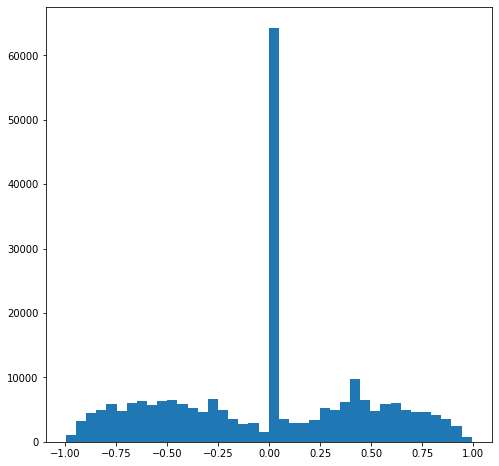

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,8)) 
histo_plot = plt.hist(dfOriginals_Analyzed['compound'],bins=40)


# Step 9. Build Classification

## Split Train and Test set

In [33]:
dfOriginals_Analyzed[['favorite_count','retweet_count','user_followers_count','compound']]

,favorite_count,retweet_count,user_followers_count,compound
3,0,0,54,0.0129
4,0,0,73,0.3400
6,0,0,55,0.4404
7,0,0,79,0.6369
12,0,0,36,0.8885
...,...,...,...,...
799126,0,0,36,-0.9267
799127,1,0,8,0.0000
799128,1,0,5,0.2023
799130,3,0,441,-0.5106


In [34]:
from sklearn import preprocessing
from sklearn import linear_model

trainSet=dfOriginals_Analyzed.sample(frac=0.8,random_state=150)
testSet=dfOriginals_Analyzed.drop(trainSet.index)

# X_train = preprocessing.scale(trainSet[['retweet_count','user_followers_count','compound','user_statuses_count','user_verified']])
# X_train = preprocessing.scale(trainSet[['user_followers_count','compound','user_statuses_count','user_verified']])
X_train = (trainSet[['retweet_count','user_followers_count','compound']])
Y_train = trainSet['favorite_count']
reg = linear_model.LinearRegression()

reg.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [35]:
# clf.predict(testSet[['retweet_count','user_followers_count','compound','user_statuses_count','user_verified',]]) #- testSet['favorite_count']
plot_1_Y = reg.predict(testSet[['retweet_count','user_followers_count','compound']]) # predicted as Y
plot_1_X = testSet['favorite_count'].reset_index()  # actual as X
df_plot_1 = pd.concat([plot_1_X,pd.DataFrame(plot_1_Y)],axis=1)
df_plot_1.columns = ['index','actual', 'predicted']
df_plot_1

,index,actual,predicted
0,56,0,2.089095
1,75,2,6.829551
2,115,1,1.998072
3,145,0,1.749808
4,149,0,1.259081
...,...,...,...
49073,799003,2,1.682046
49074,799023,0,0.187456
49075,799037,1,1.341901
49076,799056,0,0.276063


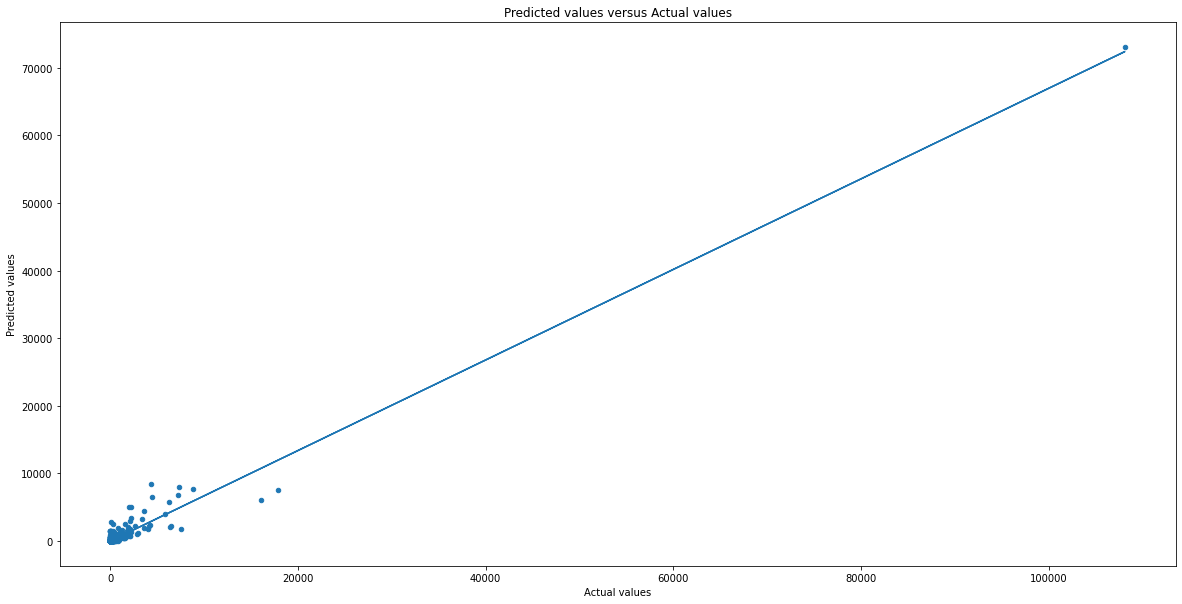

In [36]:
from numpy.polynomial.polynomial import polyfit

plot_1 = df_plot_1.plot.scatter(x='actual',y='predicted',figsize=(20,10),title="Predicted values versus Actual values")
plot_1.set_ylabel("Predicted values")
plot_1.set_xlabel("Actual values")

b, m = polyfit(df_plot_1.actual, df_plot_1.predicted, 1)
plot_1.plot(df_plot_1.actual, b + m * df_plot_1.actual, '-')



# Step 10: Getting Results

Mean Square Error

reference: https://stackoverflow.com/questions/49103139/calculating-accuracy-scores-of-predicted-continuous-values

In [37]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from math import sqrt

mse = mean_squared_error(df_plot_1.actual, df_plot_1.predicted)
print("Mean Square Error (MSE): " + str(mse))
print("Root MSE: " + str(sqrt(mse)))
print("R Square :" + str(r2_score(df_plot_1.actual, df_plot_1.predicted)))


Mean Square Error (MSE): 33369.46837319132
Root MSE: 182.6731189124205
R Square :0.8733484618869796


# Further Attempts

- Groupby user_screen_name
- calculate the mean sentiment score
- see whether there are any correlation between number of followers and number of favourite tweets against the mean sentimental score (check SD)

explain properly an understanding of why introducing new feature

In [49]:
dfOriginals.groupby('user_screen_name').size().reset_index(name='counts').sort_values(by='counts', ascending=False)

,user_screen_name,counts
27508,ELister_social,666
79905,SattarSarki1,382
133777,iHeartFun1,185
27433,EG24NEWS,181
142347,kailashscienti1,179
...,...,...
68494,Patterico,1
68495,PattheOldBat,1
68496,PattiClifford10,1
68498,PattiMurin,1
